In [2]:
import pandas as pd

import numpy as np

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Load data

## Kannada MNIST

The kannada MNIST dataset is a handwritten digits dataset which is similar to the classic MNIST dataset for the Kannada language. This dataset was used in one Kaggle playground competitions at the end of 2019. Lets take a look at it.

In [3]:
def read_kannada_dataset(path):
    dataset = pd.read_csv(path)
    
    y = dataset.iloc[:, 0].values 

    X = dataset.iloc[:, 1:].values / 255.

    X = X / X.max(axis=1, keepdims=True) # make all images range from 0 to 1.
    X = X.reshape((len(X), 28, 28))
    X = X[..., np.newaxis]
    
    return X, y

In [4]:
X, y = read_kannada_dataset(r"data/train.csv")

# Split full train set into train and validation.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2,  random_state=123)

In [5]:
def plot_kannada(X, y, num_images):
    plt.figure(figsize=(10, 8))
    for idx in range(num_images):
        plt.subplot(num_images // 5, 5, idx+1)
        plt.imshow(X[idx].reshape(28, 28), cmap="gray")
        plt.title(y[idx], fontsize=16)
        plt.axis("off")

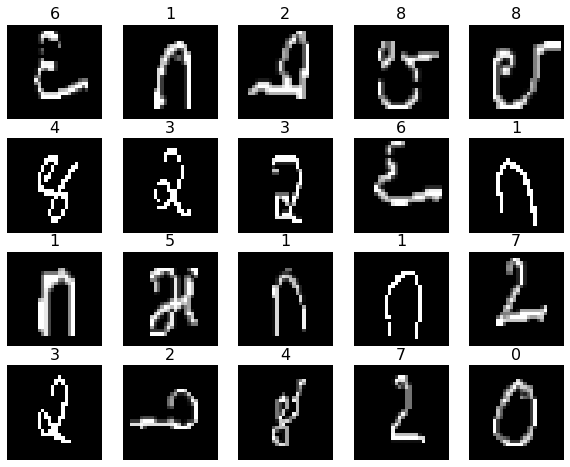

In [6]:
plot_kannada(X_train, y_train, 20)
plt.show()

Now lets look at the test set.

In [7]:
X_test, id_test = read_kannada_dataset(r"data/test.csv")

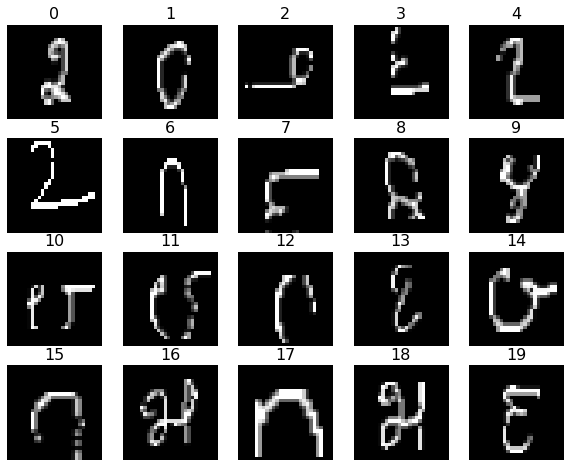

In [8]:
plot_kannada(X_test, id_test, 20)
plt.show()

By looking at the images in the test set the seem less clear than the ones on the train set. So lets creat a data generator that will disotrt the images on the train set. This will help the model to learn more generalized patterns.

In [9]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.25,
    height_shift_range = 0.25,
    shear_range = 0.15,
    zoom_range = 0.4,
    horizontal_flip = False
)

In [10]:
data_generator.fit(X_train)

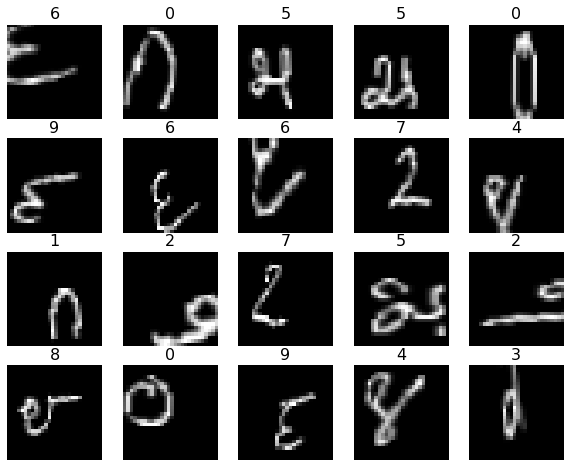

In [11]:
for X_batch, y_batch in data_generator.flow(X_train, y_train, seed=123, batch_size=20):
    plot_kannada(X_batch, y_batch, 20)
    plt.show()
    break

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)

In [13]:
# Build tensorflow dataset.
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size).prefetch(1)

# Build the model

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
model = models.Sequential([
    layers.BatchNormalization(input_shape=[28, 28, 1]),
    
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPool2D(2),
    
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPool2D(2),
    
    layers.Conv2D(256, 2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(256, 2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(256, 2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Conv2D(256, 2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPool2D(2),

    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0

In [17]:
initial_weights = model.get_weights()

## Find the best learning rate for this architecture.

To have an idea of the best learning rate to use we can increase the learning rate while training and look for the loss. I will start with a learning rate of $10^{-5}$ and increase it until $1$.

In [18]:
class ExponentialLearningRate(callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.rates = []

    def on_batch_end(self, batch, logs=None):
        self.rates.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        tf.keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [19]:
factor = 1e6 ** (1/1500)

exp_lr = ExponentialLearningRate(factor)

In [20]:
model.compile(
    optimizer=optimizers.Nadam(lr=1e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

In [21]:
history = model.fit(train_set, epochs=1, callbacks=[exp_lr])

1500/1500 [==============================] - 27s 18ms/step - loss: 740422.5000 - categorical_accuracy: 0.4853


In [22]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.ylim((min(losses), losses[0]))

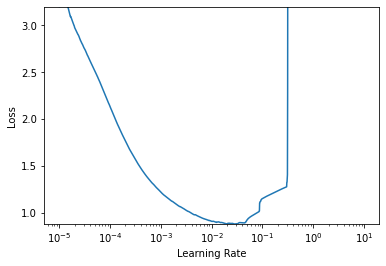

In [23]:
plot_lr_vs_loss(exp_lr.rates, exp_lr.losses)

So 0.001 should be a good learning rate to start.

# Train the model

Restore the weights to the values before the learning rate test.

In [24]:
model.set_weights(initial_weights)

In [25]:
model.compile(
    optimizer=optimizers.Nadam(lr=1e-3),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

Callbacks.

In [26]:
checkpoint_cb = callbacks.ModelCheckpoint(r"model.h5", save_best_only=True)
early_stop_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb  = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-5, verbose=1)

In [27]:
history = model.fit_generator(
    data_generator.flow(X_train, y_train, seed=42),
    epochs=100, 
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    validation_data=valid_set
)

Epoch 1/100
1500/1500 [==============================] - 34s 23ms/step - loss: 0.3421 - categorical_accuracy: 0.8925 - val_loss: 0.3118 - val_categorical_accuracy: 0.9267
Epoch 2/100
1500/1500 [==============================] - 33s 22ms/step - loss: 0.1557 - categorical_accuracy: 0.9536 - val_loss: 0.0357 - val_categorical_accuracy: 0.9899
Epoch 3/100
1500/1500 [==============================] - 34s 23ms/step - loss: 0.1239 - categorical_accuracy: 0.9614 - val_loss: 0.0382 - val_categorical_accuracy: 0.9894
Epoch 4/100
1500/1500 [==============================] - 34s 23ms/step - loss: 0.1064 - categorical_accuracy: 0.9666 - val_loss: 0.0145 - val_categorical_accuracy: 0.9958
Epoch 5/100
1500/1500 [==============================] - 33s 22ms/step - loss: 0.1025 - categorical_accuracy: 0.9688 - val_loss: 0.0207 - val_categorical_accuracy: 0.9942
Epoch 6/100
1500/1500 [==============================] - 34s 23ms/step - loss: 0.0882 - categorical_accuracy: 0.9733 - val_loss: 0.0125 - val_cat

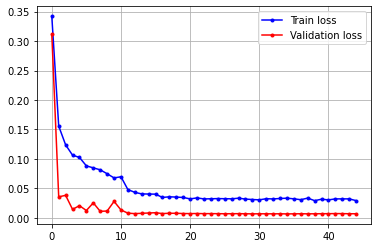

In [28]:
plt.plot(history.epoch, history.history["loss"], "b.-", label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], "r.-", label="Validation loss")
plt.grid()
plt.legend()
plt.show()

In [29]:
y_pred = model.predict_classes(X_valid)
accuracy_score(np.argmax(y_valid, axis=1), y_pred)

0.99775

In [30]:
confusion_matrix(np.argmax(y_valid, axis=1), y_pred)

array([[1196,    4,    0,    0,    0,    0,    0,    0,    0,    0],
       [   6, 1194,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1199,    1,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1200,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1197,    1,    0,    0,    1,    1],
       [   0,    0,    0,    0,    0, 1200,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1195,    3,    0,    2],
       [   0,    0,    0,    3,    0,    0,    2, 1195,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1200,    0],
       [   0,    0,    0,    0,    0,    0,    3,    0,    0, 1197]])

### Monte Carlo Drop Out

By using the drop out layers at inference we can get different predictions for the same digit (like an esemble method). 

In [31]:
y_probas = np.stack([model(X_valid, training=True) for _ in range(100)])
y_proba = y_probas.mean(axis=0)
y_pred = np.argmax(y_proba, axis=1)
accuracy_score(np.argmax(y_valid, axis=1), y_pred)

0.9983333333333333

# Make Predictions

In [32]:
y_pred = model.predict_classes(X_test)

In [33]:
y_probas = np.stack([model(X_test, training=True) for _ in range(100)])
y_proba = y_probas.mean(axis=0)
y_pred_mcdo = np.argmax(y_proba, axis=1)

In [34]:
sample_sub = pd.read_csv(f"{PATH}/sample_submission.csv")
sample_sub["label"] = y_pred

In [35]:
sample_sub.to_csv("submission.csv", index=False)

This model achieved an accuracy of $99.12\%$ on the private score and a $98.82\%$ on the public score which would be placed on the top $10\%$ of the submissions made at the time of the competition.